In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.applications import MobileNet, DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Dropout, Concatenate


In [2]:
# Dataset Path
DATASET_PATH = "Breakhis Dataset"
IMG_SIZE = (224, 224)  # Resizing images
BATCH_SIZE = 32

In [3]:
# Load Data
def load_data(dataset_path):
    X, y = [], []
    classes = {'benign': 0, 'malignant': 1}
    
    for category in classes.keys():
        category_path = os.path.join(dataset_path, category)
        for subfolder in os.listdir(category_path):
            subfolder_path = os.path.join(category_path, subfolder)
            for sample_folder in os.listdir(subfolder_path):  # Navigating sample folders
                sample_path = os.path.join(subfolder_path, sample_folder, '200X')
                if os.path.exists(sample_path):
                    for img_name in os.listdir(sample_path):
                        img_path = os.path.join(sample_path, img_name)
                        image = cv2.imread(img_path)
                        image = cv2.resize(image, IMG_SIZE)
                        image = image / 255.0  # Normalize
                        X.append(image)
                        y.append(classes[category])
    
    return np.array(X), np.array(y).reshape(-1, 1)  # Ensure labels have shape (samples, 1)

In [4]:
# Prepare Dataset
X, y = load_data(DATASET_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define Autoencoder Model
def build_autoencoder():
    input_img = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(input_img, decoded)

# Define Multi-Scale CNN Model
def build_multi_scale_cnn():
    input_layer = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)  # Ensure binary output shape (batch_size, 1)
    
    return Model(input_layer, output_layer)

# Define Pre-trained Models
def build_model(base_model):
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  # Ensure binary output shape (batch_size, 1)
    return Model(inputs=base_model.input, outputs=output)


In [6]:
# Train Autoencoder Separately
autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=10, batch_size=BATCH_SIZE, validation_data=(X_test, X_test))

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - loss: 0.0316 - val_loss: 0.0124
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - loss: 0.0112 - val_loss: 0.0086
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - loss: 0.0077 - val_loss: 0.0068
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - loss: 0.0056 - val_loss: 0.0053
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - loss: 0.0046 - val_loss: 0.0039
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 0.0027 - val_loss: 0.0025
Epoch 10/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - loss: 0.0024 - val_loss: 0.0025


In [7]:
# Evaluate Autoencoder
y_pred_autoencoder = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - y_pred_autoencoder), axis=(1, 2, 3))
threshold = np.percentile(mse, 95)
y_pred_binary = (mse > threshold).astype(int)

# Metrics for Autoencoder
autoencoder_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_binary),
    'Precision': precision_score(y_test, y_pred_binary),
    'Recall': recall_score(y_test, y_pred_binary),
    'F1 Score': f1_score(y_test, y_pred_binary)
}

print("Autoencoder Metrics:", autoencoder_metrics)

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step
Autoencoder Metrics: {'Accuracy': 0.3523573200992556, 'Precision': 0.6190476190476191, 'Recall': 0.04887218045112782, 'F1 Score': 0.09059233449477351}


In [11]:
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Define Unique Model Architectures
def build_mffdcnn_ctdc():
    input_layer = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    return Model(input_layer, output_layer)

def build_amcscc_whoel():
    input_layer = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    return Model(input_layer, output_layer)


def build_mafcnn_scd():
    input_layer = Input(shape=(224, 224, 3))
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    return Model(input_layer, output_layer)


def build_ensemble():
    input_layer = Input(shape=(224, 224, 3))
    # First CNN branch
    x1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x1 = MaxPooling2D((2,2))(x1)
    x1 = Flatten()(x1)
    # Second CNN branch
    x2 = Conv2D(32, (5,5), activation='relu', padding='same')(input_layer)
    x2 = MaxPooling2D((2,2))(x2)
    x2 = Flatten()(x2)
    # Concatenation of both CNN features
    merged = Concatenate()([x1, x2])
    # Fully connected layers
    x = Dense(128, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(x)
     
    return Model(input_layer, output)

def build_kernel_elm():
    return build_mffdcnn_ctdc()

def build_msvm_method():
    return build_mffdcnn_ctdc()

In [12]:
# All Classification Models
models = {
    'Ensemble': build_ensemble(),
    'MAFCNN-SCD': build_mafcnn_scd(),
    'Kernel-ELM': build_kernel_elm(),
    'MSVM Method': build_msvm_method(),
    'Multi-Scale CNN': build_multi_scale_cnn(),
    'MobileNet': build_model(MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    'DenseNet169': build_model(DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    'MFFDCNN-CTDC': build_mffdcnn_ctdc(),
    'AMCSCC-WHOEL': build_amcscc_whoel()
}

Training Ensemble Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6253 - loss: 16.4966 - val_accuracy: 0.8635 - val_loss: 0.3916
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8400 - loss: 0.4217 - val_accuracy: 0.8610 - val_loss: 0.3880
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8486 - loss: 0.4126 - val_accuracy: 0.8486 - val_loss: 0.3968
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8763 - loss: 0.3514 - val_accuracy: 0.8660 - val_loss: 0.3859
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8705 - loss: 0.3399 - val_accuracy: 0.8561 - val_loss: 0.3764
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step


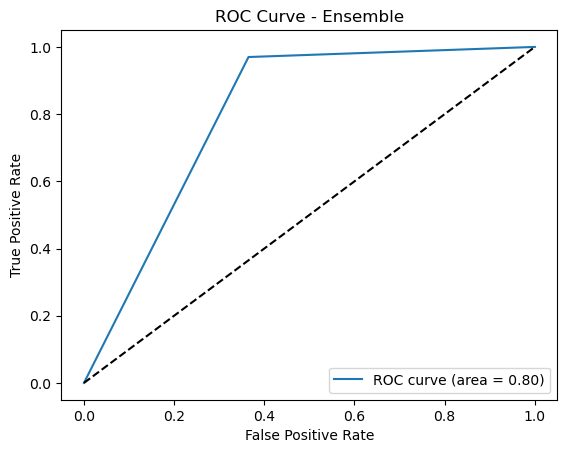

Training MAFCNN-SCD Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.6572 - loss: 0.6056 - val_accuracy: 0.6600 - val_loss: 0.6471
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.7532 - loss: 0.5257 - val_accuracy: 0.8660 - val_loss: 0.4415
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.8452 - loss: 0.4595 - val_accuracy: 0.8536 - val_loss: 0.4437
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.8413 - loss: 0.4289 - val_accuracy: 0.7196 - val_loss: 0.5364
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.7971 - loss: 0.4639 - val_accuracy: 0.8710 - val_loss: 0.4117
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 868ms/step


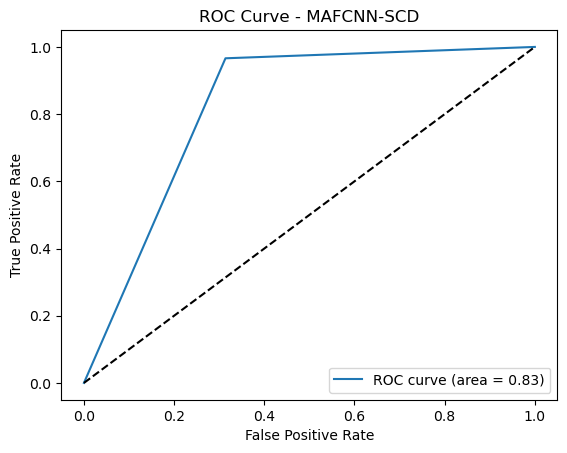

Training Kernel-ELM Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7741 - loss: 0.5034 - val_accuracy: 0.6600 - val_loss: 0.6230
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8446 - loss: 0.3982 - val_accuracy: 0.6600 - val_loss: 0.6332
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8737 - loss: 0.3586 - val_accuracy: 0.6600 - val_loss: 0.6162
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8512 - loss: 0.3697 - val_accuracy: 0.6600 - val_loss: 0.6334
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8720 - loss: 0.3083 - val_accuracy: 0.6600 - val_loss: 0.5850
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step


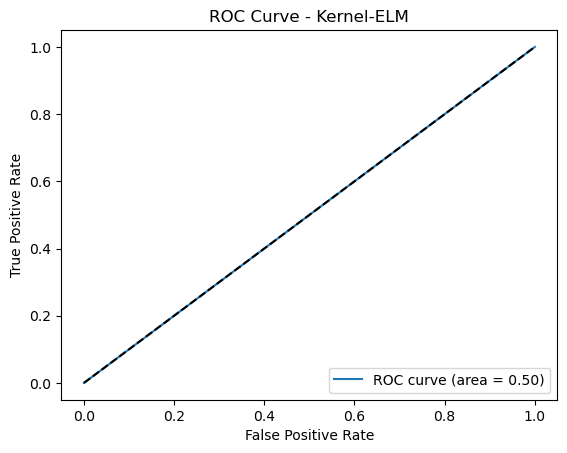

Training MSVM Method Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8082 - loss: 0.4834 - val_accuracy: 0.6600 - val_loss: 0.6199
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8710 - loss: 0.3688 - val_accuracy: 0.6600 - val_loss: 0.6260
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8657 - loss: 0.3552 - val_accuracy: 0.6600 - val_loss: 0.6261
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8728 - loss: 0.3462 - val_accuracy: 0.6600 - val_loss: 0.6377
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8809 - loss: 0.3296 - val_accuracy: 0.6600 - val_loss: 0.7039
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step


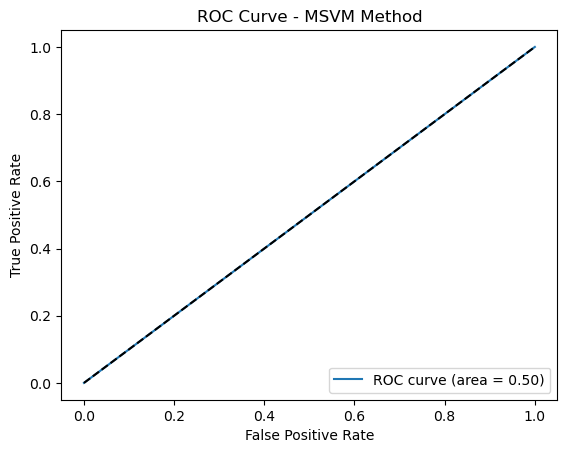

Training Multi-Scale CNN Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6362 - loss: 3.1897 - val_accuracy: 0.6625 - val_loss: 0.5269
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7846 - loss: 0.5063 - val_accuracy: 0.6600 - val_loss: 0.7805
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6823 - loss: 0.6139 - val_accuracy: 0.8536 - val_loss: 0.4621
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.8252 - loss: 0.4368 - val_accuracy: 0.8635 - val_loss: 0.3925
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8239 - loss: 0.4300 - val_accuracy: 0.7742 - val_loss: 0.4991
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step


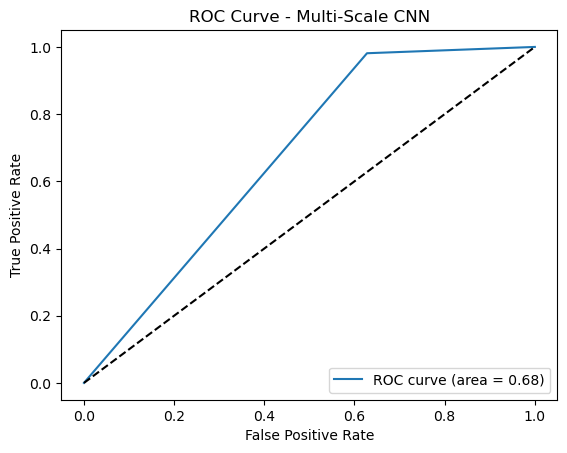

Training MobileNet Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 53s 954ms/step - accuracy: 0.6881 - loss: 4.7727 - val_accuracy: 0.8213 - val_loss: 0.4954
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 890ms/step - accuracy: 0.9226 - loss: 0.2326 - val_accuracy: 0.8536 - val_loss: 0.3719
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 821ms/step - accuracy: 0.9961 - loss: 0.0249 - val_accuracy: 0.8635 - val_loss: 0.3892
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 830ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.8635 - val_loss: 0.4011
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 817ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8685 - val_loss: 0.4045
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 652ms/step


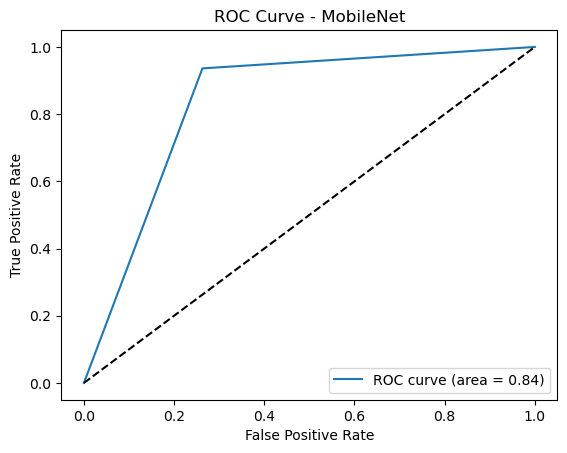

Training DenseNet169 Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.6339 - loss: 3.4015 - val_accuracy: 0.6600 - val_loss: 0.4819
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.8116 - loss: 0.3601 - val_accuracy: 0.8809 - val_loss: 0.3074
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - accuracy: 0.9371 - loss: 0.1976 - val_accuracy: 0.8933 - val_loss: 0.2618
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.9794 - loss: 0.1253 - val_accuracy: 0.8958 - val_loss: 0.2403
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 317s 5s/step - accuracy: 0.9918 - loss: 0.0694 - val_accuracy: 0.8908 - val_loss: 0.2878
13/13 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step


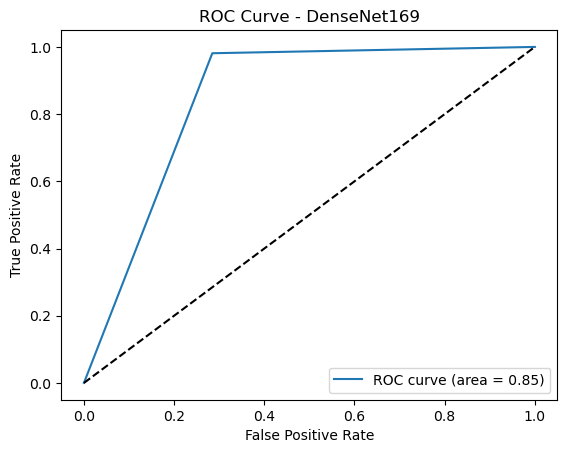

Training MFFDCNN-CTDC Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8406 - loss: 0.4482 - val_accuracy: 0.6600 - val_loss: 0.6257
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8547 - loss: 0.3765 - val_accuracy: 0.6600 - val_loss: 0.6260
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8838 - loss: 0.3244 - val_accuracy: 0.6600 - val_loss: 0.6490
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8576 - loss: 0.3382 - val_accuracy: 0.6600 - val_loss: 0.6327
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8581 - loss: 0.3394 - val_accuracy: 0.6600 - val_loss: 0.7491
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step


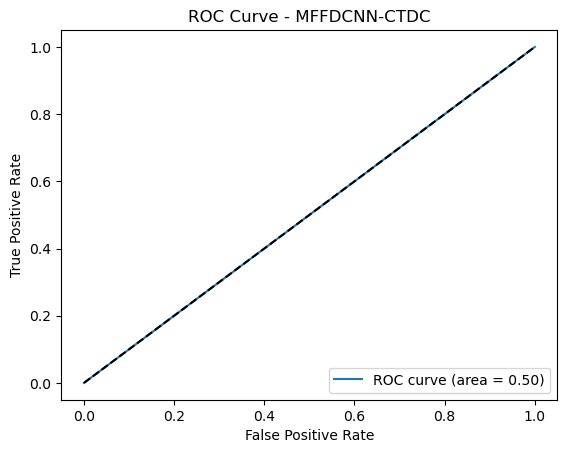

Training AMCSCC-WHOEL Model
Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.6828 - loss: 1.6422 - val_accuracy: 0.7891 - val_loss: 0.4555
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.8178 - loss: 0.4672 - val_accuracy: 0.8759 - val_loss: 0.3951
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8360 - loss: 0.4188 - val_accuracy: 0.8710 - val_loss: 0.4088
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.8579 - loss: 0.3865 - val_accuracy: 0.8313 - val_loss: 0.4430
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.8641 - loss: 0.3745 - val_accuracy: 0.8635 - val_loss: 0.3809
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step


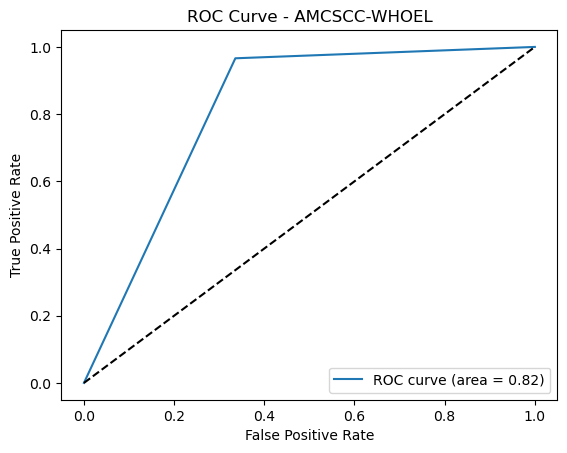

In [13]:
# Train & Evaluate Classification Models
results = {}
for model_name, model in models.items():
    print(f"Training {model_name} Model")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=5, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))
    
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc_score
    }
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


In [14]:
# Print Results
for model_name, metrics in results.items():
    print(f"{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("------------------------------")

Ensemble Performance:
Accuracy: 0.8561
Precision: 0.8377
Recall: 0.9699
F1 Score: 0.8990
AUC: 0.8025
------------------------------
MAFCNN-SCD Performance:
Accuracy: 0.8710
Precision: 0.8567
Recall: 0.9662
F1 Score: 0.9081
AUC: 0.8261
------------------------------
Kernel-ELM Performance:
Accuracy: 0.6600
Precision: 0.6600
Recall: 1.0000
F1 Score: 0.7952
AUC: 0.5000
------------------------------
MSVM Method Performance:
Accuracy: 0.6600
Precision: 0.6600
Recall: 1.0000
F1 Score: 0.7952
AUC: 0.5000
------------------------------
Multi-Scale CNN Performance:
Accuracy: 0.7742
Precision: 0.7522
Recall: 0.9812
F1 Score: 0.8515
AUC: 0.6767
------------------------------
MobileNet Performance:
Accuracy: 0.8685
Precision: 0.8737
Recall: 0.9361
F1 Score: 0.9038
AUC: 0.8367
------------------------------
DenseNet169 Performance:
Accuracy: 0.8908
Precision: 0.8700
Recall: 0.9812
F1 Score: 0.9223
AUC: 0.8483
------------------------------
MFFDCNN-CTDC Performance:
Accuracy: 0.6600
Precision: 0.66

In [15]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def build_cnn_svm(X_train, y_train):
    # CNN Feature Extractor
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    feature_extractor.trainable = False  # Freeze CNN layers

    # Extract Features
    X_train_features = feature_extractor.predict(X_train)
    print(f"Extracted Features Shape: {X_train_features.shape}")  # Debugging

    # Train SVM on extracted features
    svm_classifier = SVC(kernel='linear', probability=True)
    svm_classifier.fit(X_train_features, y_train.ravel())

    return feature_extractor, svm_classifier  # Return both models

# Build & Train CNN + SVM
feature_extractor, svm_model = build_cnn_svm(X_train, y_train)

# Extract features for the test set
X_test_features = feature_extractor.predict(X_test)

# Predict using SVM
y_pred_svm = svm_model.predict(X_test_features)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

print(f"SVM Model Accuracy: {accuracy}")
print(f"SVM Model Precision: {precision}")
print(f"SVM Model Recall: {recall}")
print(f"SVM Model F1 Score: {f1}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 808ms/step
Extracted Features Shape: (1610, 1024)
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 752ms/step
SVM Model Accuracy: 0.8808933002481389
SVM Model Precision: 0.916030534351145
SVM Model Recall: 0.9022556390977443
SVM Model F1 Score: 0.9090909090909091


In [16]:
def build_cnn_nb(X_train, y_train):
    # CNN Feature Extractor
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    feature_extractor.trainable = False  # Freeze CNN layers

    # Extract Features
    X_train_features = feature_extractor.predict(X_train)
    print(f"Extracted Features Shape: {X_train_features.shape}")  # Debugging

    # Train Naïve Bayes on extracted features
    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train_features, y_train.ravel())

    return feature_extractor, nb_classifier  # Return both models

# Build & Train CNN + Naïve Bayes
feature_extractor, nb_model = build_cnn_nb(X_train, y_train)

# Extract features for the test set
X_test_features = feature_extractor.predict(X_test)

# Predict using Naïve Bayes
y_pred_nb = nb_model.predict(X_test_features)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred_nb)
precision = precision_score(y_test, y_pred_nb)
recall = recall_score(y_test, y_pred_nb)
f1 = f1_score(y_test, y_pred_nb)

print(f"Naïve Bayes Model Accuracy: {accuracy}")
print(f"Naïve Bayes Model Precision: {precision}")
print(f"Naïve Bayes Model Recall: {recall}")
print(f"Naïve Bayes Model F1 Score: {f1}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 799ms/step
Extracted Features Shape: (1610, 1024)
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 745ms/step
Naïve Bayes Model Accuracy: 0.7245657568238213
Naïve Bayes Model Precision: 0.8780487804878049
Naïve Bayes Model Recall: 0.6766917293233082
Naïve Bayes Model F1 Score: 0.7643312101910829


In [18]:
for name, model in models.items():
    model.save(f"Breakhis_Models/{name}.h5")
    print(f"Saved {name}.h5")

Saved Ensemble.h5
Saved MAFCNN-SCD.h5
Saved Kernel-ELM.h5
Saved MSVM Method.h5


Saved Multi-Scale CNN.h5


Saved MobileNet.h5


Saved DenseNet169.h5
Saved MFFDCNN-CTDC.h5
Saved AMCSCC-WHOEL.h5


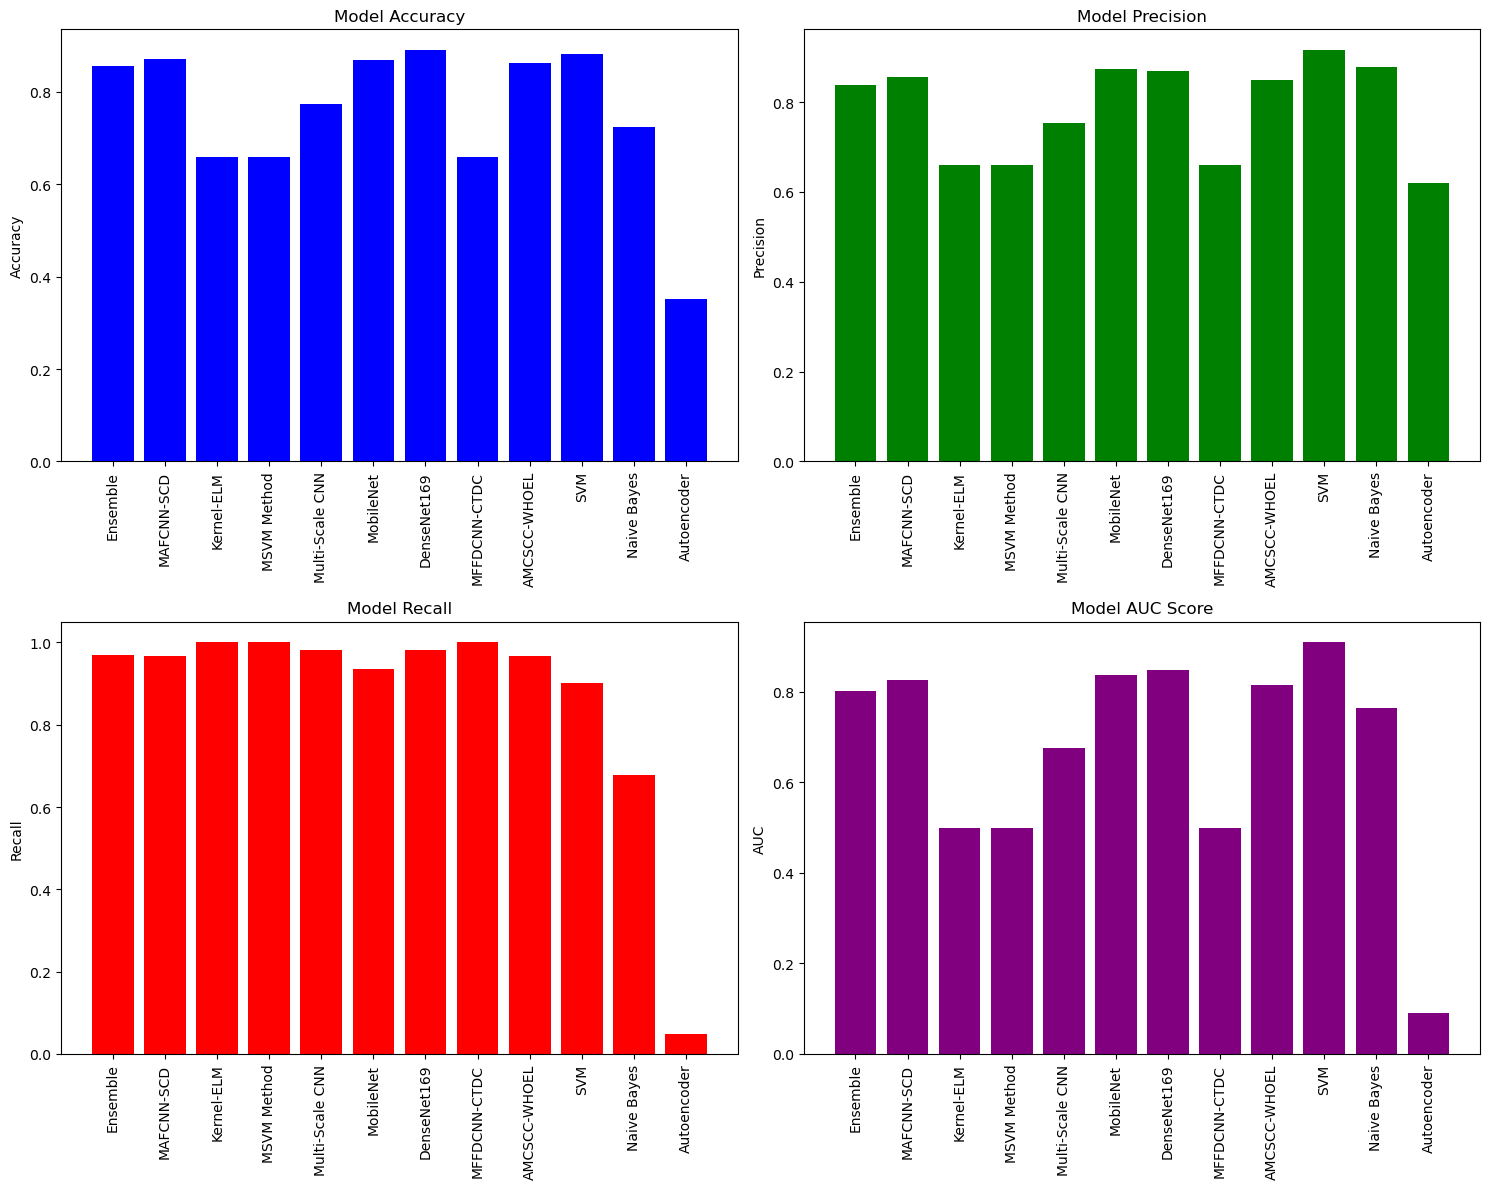

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and corresponding metrics
models = ["Ensemble", "MAFCNN-SCD", "Kernel-ELM", "MSVM Method", "Multi-Scale CNN", "MobileNet", "DenseNet169", "MFFDCNN-CTDC", "AMCSCC-WHOEL", "SVM", "Naive Bayes", "Autoencoder"]
accuracy = [0.8561, 0.8710, 0.6600, 0.6600, 0.7742, 0.8685, 0.8908, 0.6600, 0.8635, 0.8809, 0.7245, 0.3523]
precision = [0.8377, 0.8567, 0.6600, 0.6600, 0.7522, 0.8737, 0.8700, 0.6600, 0.8482, 0.9160, 0.8780, 0.6190]
recall = [0.9699, 0.9662, 1.0000, 1.0000, 0.9812, 0.9361, 0.9812, 1.0000, 0.9662, 0.9022, 0.6766, 0.0488]
auc = [0.8025, 0.8261, 0.5000, 0.5000, 0.6767, 0.8367, 0.8483, 0.5000, 0.8152, 0.9090, 0.7643, 0.0905]

# Plotting metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy Plot
axes[0, 0].bar(models, accuracy, color='blue')
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].tick_params(axis='x', rotation=90)

# Precision Plot
axes[0, 1].bar(models, precision, color='green')
axes[0, 1].set_title("Model Precision")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].tick_params(axis='x', rotation=90)

# Recall Plot
axes[1, 0].bar(models, recall, color='red')
axes[1, 0].set_title("Model Recall")
axes[1, 0].set_ylabel("Recall")
axes[1, 0].tick_params(axis='x', rotation=90)

# AUC Plot
axes[1, 1].bar(models, auc, color='purple')
axes[1, 1].set_title("Model AUC Score")
axes[1, 1].set_ylabel("AUC")
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Model Performance Analysis

### Overview of Model Performance

The evaluation of different models for classification tasks shows a significant variance in accuracy, precision, recall, and F1 score. Below is a summary of the key findings:

Top-performing models: DenseNet169 (Accuracy: 89.08%), MAFCNN-SCD (87.10%), and MobileNet (86.85%).

Balanced performance: Ensemble (85.61%) and AMCSCC-WHOEL (86.35%) maintained a good trade-off between precision and recall.

Weaker models: Kernel-ELM, MSVM Method, and MFFDCNN-CTDC had significantly lower AUC scores (0.50), indicating poor discrimination ability.

###  Key Observations

DenseNet169 & MobileNet showed the highest accuracy and F1 scores, making them the best-performing models overall.

Kernel-ELM, MSVM, and MFFDCNN-CTDC struggled, indicating that these methods may not be ideal for this classification task.

Autoencoder had the weakest performance, suggesting that it may require further optimization or a better-suited dataset.

SVM outperformed Naïve Bayes, highlighting that feature extraction using CNN is more effective for classification tasks.

###  Conclusion

From the results, DenseNet169 and MAFCNN-SCD are recommended for classification due to their high accuracy, recall, and balanced precision. Ensemble models also provide competitive results.

Future improvements could include hyperparameter tuning, ensembling multiple high-performing models, or experimenting with deeper CNN architectures to enhance classification accuracy further.